In [1]:
import numpy as np
import os
import xml.etree.ElementTree as ET
from typing import List, Tuple, Union

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.file_io import PathManager

In [2]:
__all__ = ["load_voc_instances", "register_pascal_voc"]


# fmt: off
CLASS_NAMES = (
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
)
# fmt: on

In [3]:
def load_voc_instances(dirname: str, split: str, class_names: Union[List[str], Tuple[str, ...]]):
    """
    Load Pascal VOC detection annotations to Detectron2 format.

    Args:
        dirname: Contain "Annotations", "ImageSets", "JPEGImages"
        split (str): one of "train", "test", "val", "trainval"
        class_names: list or tuple of class names
    """
    with PathManager.open(os.path.join(dirname, "ImageSets", "Main", split + ".txt")) as f:
        fileids = np.loadtxt(f, dtype=str)

    # Needs to read many small annotation files. Makes sense at local
    annotation_dirname = PathManager.get_local_path(os.path.join(dirname, "Annotations/"))
    dicts = []
    for fileid in fileids:
        anno_file = os.path.join(annotation_dirname, fileid[0] + ".xml")
        jpeg_file = os.path.join(dirname, "JPEGImages", fileid[0] + ".jpg")

        with PathManager.open(anno_file) as f:
            tree = ET.parse(f)

        r = {
            "file_name" : jpeg_file,
            "image_id" : fileid,
            "height" : int(tree.findall("./size/height")[0].text),
            "width" : int(tree.findall("./size/width")[0].text),
        }

        instances = []
        for obj in tree.findall("object"):
            objcls = obj.find("name").text
            # We include "difficult" samples in training.
            # Based on limited experiments, they don't hurt accuracy.
            # difficult = int(obj.find("difficult").text)
            # if difficult == 1:
            #     continue
        
            bbox = obj.find("bndbox")
            bbox = [float(bbox.find(x).text) for x in ["xmin", "ymin", "xmax", "ymax"]]
            # Original annotations are integers in the range [1, W or H]
            # Assuming they mean 1-based pixel indices (inclusive),
            # a box with annotation (xmin=1, xmax=W) covers the whole image.
            # In coordinate space this is represented by (xmin=0, xmax=W)
            bbox[0] -= 1.0
            bbox[1] -= 1.0
            instances.append({
                "category_id": class_names.index(objcls), 
                "bbox": bbox, 
                "bbox_mode": BoxMode.XYXY_ABS}
            )
        
        r["annotations"] = instances
        dicts.append(r)
    return dicts


In [4]:
def register_pascal_voc(name, dirname, split, year, class_names=CLASS_NAMES):
    DatasetCatalog.register(name, lambda: load_voc_instances(dirname, split, class_names))
    MetadataCatalog.get(name).set(
        thing_classes=list(class_names), 
        dirname=dirname,
        year=year, 
        split=split
    )

In [5]:
for d in ["train", "val"]:
    register_pascal_voc("voc_"+ d, "VOCtrainval_11-May-2012/VOCdevkit/VOC2012", split="person_"+d, year=2012, class_names=CLASS_NAMES)

In [6]:
voc_metadata = MetadataCatalog.get("voc_train")
dataset_dicts = load_voc_instances("VOCtrainval_11-May-2012/VOCdevkit/VOC2012", split="person_train", class_names=CLASS_NAMES)

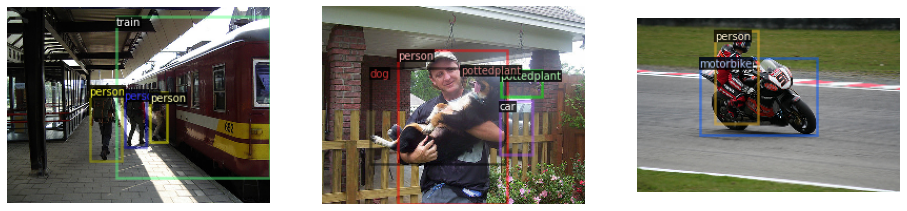

In [7]:
import random, cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

fig = plt.figure(figsize=(16, 16))

for i, d in enumerate(random.sample(dataset_dicts, 3)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=voc_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(out.get_image()[:, :, :])
    ax.axis("off")

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml")) 

#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("voc_train",)
cfg.DATASETS.TEST = ("voc_val",)

# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml")  

# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 1500  #No. of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.TEST.EVAL_PERIOD = 500 # No. of iterations after which the Validation Set is evaluated.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/22 14:36:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

/home/konishi/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[09/22 14:37:36 d2.utils.events]:  eta: 0:55:01  iter: 19  total_loss: 0.5416  loss_cls: 0.117  loss_box_reg: 0.2585  loss_rpn_cls: 0.04585  loss_rpn_loc: 0.08817  time: 2.3038  data_time: 0.0141  lr: 0.0023851  max_mem: 5519M
[09/22 14:38:23 d2.utils.events]:  eta: 0:57:42  iter: 39  total_loss: 0.4539  loss_cls: 0.06951  loss_box_reg: 0.2182  loss_rpn_cls: 0.04198  loss_rpn_loc: 0.1072  time: 2.3407  data_time: 0.0049  lr: 0.0048826  max_mem: 5519M
[09/22 14:39:11 d2.utils.events]:  eta: 0:57:14  iter: 59  total_loss: 0.6478  loss_cls: 0.1542  loss_box_reg: 0.2846  loss_rpn_cls: 0.0738  loss_rpn_loc: 0.1019  time: 2.3578  data_time: 0.0049  lr: 0.0073801  max_mem: 5519M
[09/22 14:39:57 d2.utils.events]:  eta: 0:55:25  iter: 79  total_loss: 0.7144  loss_cls: 0.1952  loss_box_reg: 0.3066  loss_rpn_cls: 0.08837  loss_rpn_loc: 0.1371  time: 2.3336  data_time: 0.0051  lr: 0.0098776  max_mem: 5531M
[09/22 14:40:41 d2.utils.events]:  eta: 0:54:03  iter: 99  total_loss: 0.7976  loss_cls: 0.2

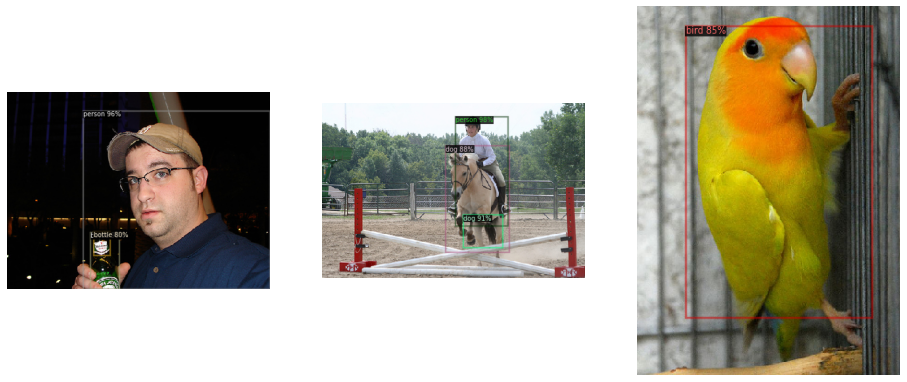

In [11]:
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultPredictor

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("voc_val", )

predictor = DefaultPredictor(cfg)

dataset_dicts = load_voc_instances("VOCtrainval_11-May-2012/VOCdevkit/VOC2012", split="person_val", class_names=CLASS_NAMES)

fig = plt.figure(figsize=(16, 16))
for i, d in enumerate(random.sample(dataset_dicts, 3)):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=voc_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(v.get_image()[:, :, :])
    ax.axis("off")


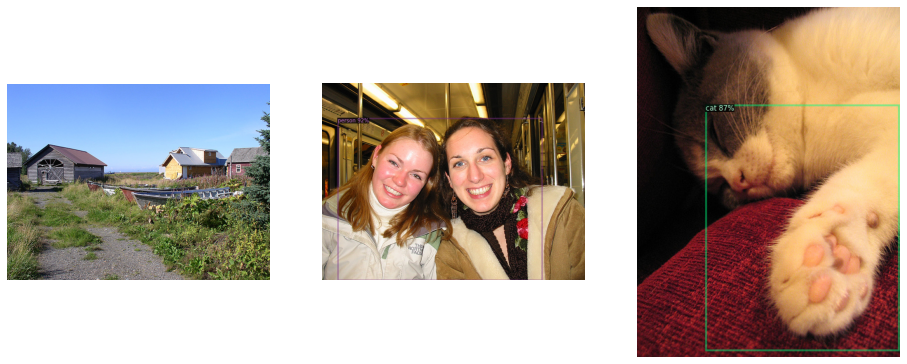

In [12]:
fig = plt.figure(figsize=(16, 16))
for i, d in enumerate(random.sample(dataset_dicts, 3)):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=voc_metadata, 
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(v.get_image()[:, :, :])
    ax.axis("off")
